In [2]:
from google.colab import drive

# Mount to a valid directory path (e.g., /content/drive)
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd


In [4]:
healthy_path = '/content/drive/MyDrive/spiral/training/healthy'
parkinson_path = '/content/drive/MyDrive/spiral/training/parkinson'

In [5]:
data = []

for file in os.listdir(healthy_path):
    if file.endswith((".png", ".jpg")):  # More efficient checking
        data.append([os.path.join(healthy_path, file), 'healthy'])

for file in os.listdir(parkinson_path):
    if file.endswith((".png", ".jpg")):
        data.append([os.path.join(parkinson_path, file), 'parkinson'])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Display the DataFrame
df.head()

,file_path,label
0,/content/drive/MyDrive/spiral/training/healthy...,healthy
1,/content/drive/MyDrive/spiral/training/healthy...,healthy
2,/content/drive/MyDrive/spiral/training/healthy...,healthy
3,/content/drive/MyDrive/spiral/training/healthy...,healthy
4,/content/drive/MyDrive/spiral/training/healthy...,healthy


In [6]:
df.tail()

,file_path,label
67,/content/drive/MyDrive/spiral/training/parkins...,parkinson
68,/content/drive/MyDrive/spiral/training/parkins...,parkinson
69,/content/drive/MyDrive/spiral/training/parkins...,parkinson
70,/content/drive/MyDrive/spiral/training/parkins...,parkinson
71,/content/drive/MyDrive/spiral/training/parkins...,parkinson


In [7]:
df.shape

(72, 2)

In [8]:
df.columns

Index(['file_path', 'label'], dtype='object')

In [9]:
df.info

<bound method DataFrame.info of                                             file_path      label
0   /content/drive/MyDrive/spiral/training/healthy...    healthy
1   /content/drive/MyDrive/spiral/training/healthy...    healthy
2   /content/drive/MyDrive/spiral/training/healthy...    healthy
3   /content/drive/MyDrive/spiral/training/healthy...    healthy
4   /content/drive/MyDrive/spiral/training/healthy...    healthy
..                                                ...        ...
67  /content/drive/MyDrive/spiral/training/parkins...  parkinson
68  /content/drive/MyDrive/spiral/training/parkins...  parkinson
69  /content/drive/MyDrive/spiral/training/parkins...  parkinson
70  /content/drive/MyDrive/spiral/training/parkins...  parkinson
71  /content/drive/MyDrive/spiral/training/parkins...  parkinson

[72 rows x 2 columns]>

In [10]:
df.nunique()

,0
file_path,72
label,2


In [11]:
df['label'].unique()

array(['healthy', 'parkinson'], dtype=object)

In [12]:
df['label'].value_counts()

,count
label,
healthy,36
parkinson,36


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-14-85827d6e6169>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


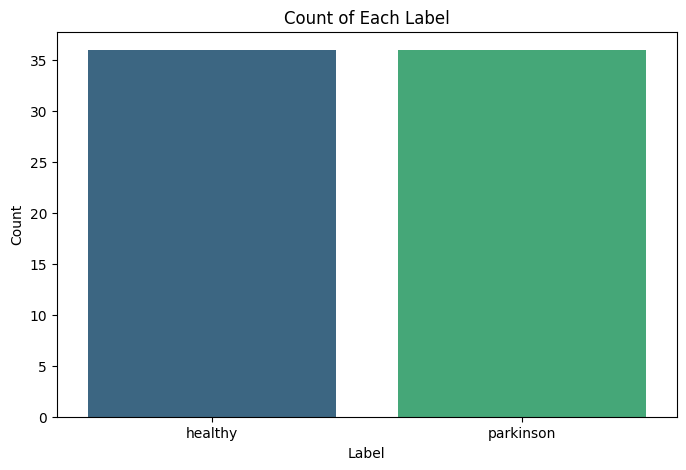

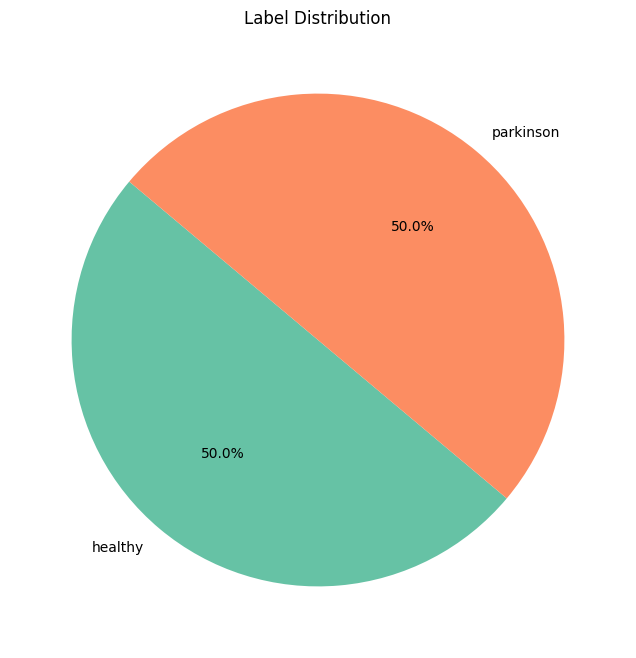

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Count of Each Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 8))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title("Label Distribution")
plt.ylabel("")
plt.show()

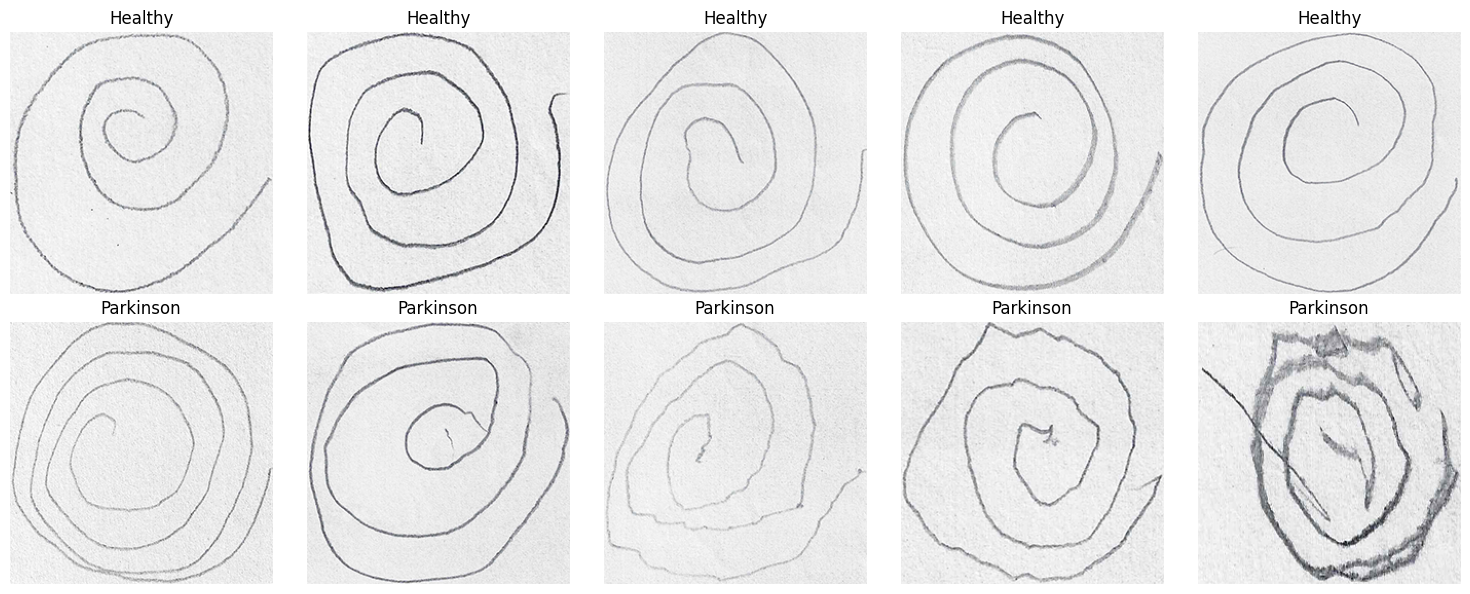

In [15]:
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img_healthy = Image.open(df[df['label'] == 'healthy'].iloc[i]['file_path'])
    axes[0, i].imshow(img_healthy, cmap='gray')
    axes[0, i].set_title("Healthy")
    axes[0, i].axis('off')

    img_parkinson = Image.open(df[df['label'] == 'parkinson'].iloc[i]['file_path'])
    axes[1, i].imshow(img_parkinson, cmap='gray')
    axes[1, i].set_title("Parkinson")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [16]:
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [17]:
train_df_new, temp_df_new = train_test_split(
    df,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df['label']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['label']
)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Augmentations for Training
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    zoom_range=0.2,  # Zoom in/out
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest'  # Fill missing pixels after transformation
)

# No augmentation for validation/testing, only rescaling
ts_gen = ImageDataGenerator(rescale=1./255)

# Training Data Generator
train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation Data Generator
valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Test Data Generator (No shuffling)
test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 57 validated image filenames belonging to 2 classes.
Found 7 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_inception_model(input_shape):

    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 5, 5, 2048
    x = Reshape((height * width, channels))(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    attention_output = Reshape((height, width, channels))(attention_output)

    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.5385 - loss: 0.9479 - val_accuracy: 0.4286 - val_loss: 0.9133
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.6957 - loss: 0.5729 - val_accuracy: 0.4286 - val_loss: 1.9206
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.6571 - loss: 0.7462 - val_accuracy: 0.7143 - val_loss: 0.7082
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7731 - loss: 0.4913 - val_accuracy: 0.7143 - val_loss: 0.6013
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.7864 - loss: 0.5553 - val_accuracy: 0.7143 - val_loss: 1.1462
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7865 - loss: 0.4781 - val_accuracy: 0.7143 - val_loss: 0.7022
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.8285 - loss: 0.4580 - val_accuracy: 1.0000 - val_loss: 0.3820
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.8966 - loss: 0.2255 - val_accuracy: 0.7143 - val_loss: 0

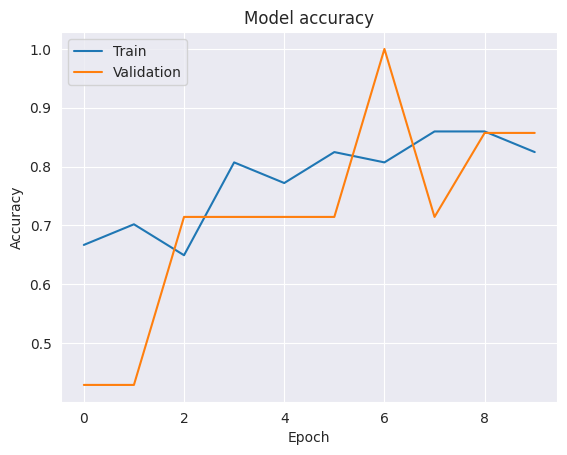

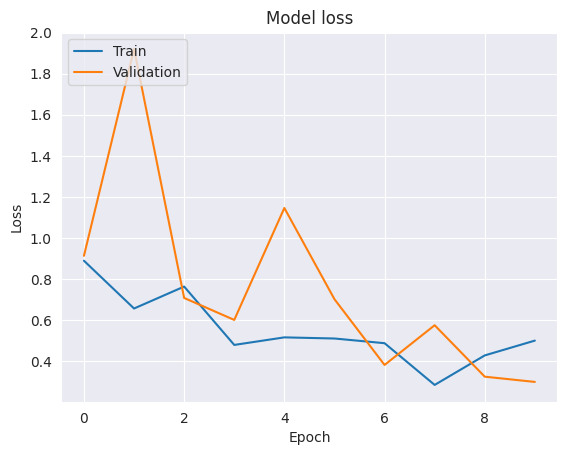

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_labels = (predictions > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [25]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_labels, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

     healthy       1.00      0.25      0.40         4
   parkinson       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8



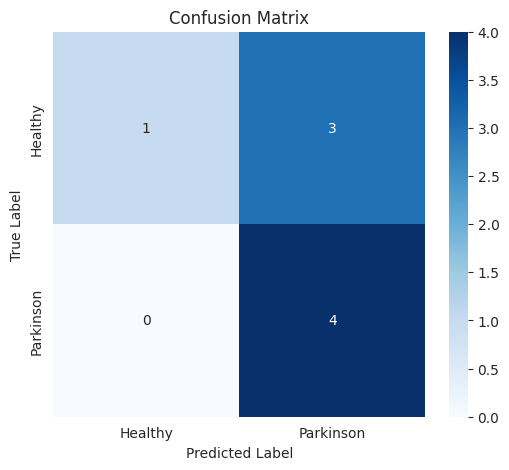

In [26]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
cnn_model.save("parkinsons_model.h5")


In [28]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00


In [29]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load your trained model
model = tf.keras.models.load_model("/content/parkinsons_model.h5")  # Replace with the actual model path

# Define class labels (only 2 classes)
class_labels = {
    0: "Healthy",
    1: "Parkinson’s Disease"
}

# Function to predict disease
def predict_disease(image):
    # Preprocess the image
    image = image.resize((224, 224))  # Resize to match model input
    img_array = np.array(image) / 255.0  # Normalize pixel values
    img_array = img_array.reshape(1, 224, 224, 3)  # Reshape for model

    # Make prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)  # Get the class with the highest probability
    confidence = np.max(prediction) * 100  # Convert confidence to percentage

    # Get class name
    class_name = class_labels.get(class_index, "Unknown")

    return f"Prediction: {class_name} (Confidence: {confidence:.2f}%)"

# Create Gradio interface
interface = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Parkinson’s Disease Detection",
    description="Upload an image and the model will predict if the person is Healthy or has Parkinson’s Disease.",
)

# Launch the app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://365ba3d86ecc7d7274.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
